In [1]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def compute_pairwise_distances(X):
    """
    Вычисление попарных евклидовых расстояний между всеми точками в матрице X.

    Параметры:
        X (numpy.ndarray): Матрица данных размером (n_samples, n_features),
                           где каждая строка — это точка в пространстве.

    Возвращает:
        numpy.ndarray: Матрица попарных расстояний размером (n_samples, n_samples).
    """
    # Сумма квадратов по каждой строке (n_samples,).
    sum_X = np.sum(X**2, axis=1)
    
    # Матрица квадратов расстояний:
    # dist_ij = ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i * x_j
    distances_squared = sum_X[:, None] + sum_X[None, :] - 2 * np.dot(X, X.T)
    
    # Убираем отрицательные значения, вызванные числовой погрешностью
    distances_squared = np.maximum(distances_squared, 0)
    
    # Приводим к обычным расстояниям
    distances = np.sqrt(distances_squared)
    
    # Зануляем диагональ (расстояние от точки до самой себя)
    np.fill_diagonal(distances, 0)
    
    return distances


In [3]:
def compute_conditional_probabilities(distances, perplexity):
    """
    Вычисление условных вероятностей p_{j|i} с использованием бинарного поиска для подбора sigma.

    Параметры:
        distances (numpy.ndarray): Матрица попарных расстояний (n_samples, n_samples).
        perplexity (float): Желаемая запутанность (perplexity).

    Возвращает:
        numpy.ndarray: Матрица условных вероятностей (n_samples, n_samples).
    """
    n = distances.shape[0]
    target_entropy = np.log(perplexity)

    def binary_search_sigma(i):
        """Подбор sigma методом бинарного поиска."""
        beta = 1.0  # Начальное значение beta (1 / sigma^2)
        min_beta, max_beta = 1e-5, 100  # Границы поиска
        for _ in range(50):  # Максимум 50 итераций
            # Вычисляем вероятности для текущего beta
            p = np.exp(-distances[i] * beta)
            p[i] = 0  # Обнуляем вероятность для самой точки
            sum_p = np.sum(p)
            if sum_p == 0:
                continue  # Избегаем деления на ноль
            p /= sum_p

            # Энтропия
            entropy = -np.sum(p * np.log(p + 1e-8))
            error = entropy - target_entropy

            # Бинарный поиск
            if abs(error) < 1e-5:
                break
            if error > 0:
                min_beta = beta
                beta = (beta + max_beta) / 2 if max_beta < 100 else beta * 2
            else:
                max_beta = beta
                beta = (beta + min_beta) / 2

        return beta

    # Вычисление вероятностей P
    P = np.zeros_like(distances)
    for i in range(n):
        beta = binary_search_sigma(i)
        p = np.exp(-distances[i] * beta)
        p[i] = 0
        P[i] = p / np.sum(p)  # Нормализация

    return P

In [4]:
def symmetrize_probabilities(P):
    """
    Симметризация матрицы вероятностей: p_{ij} = (p_{i|j} + p_{j|i}) / (2N).
    """
    return (P + P.T) / (2 * P.shape[0])

In [5]:
def compute_low_dimensional_probabilities(Y, alpha=1.0):
    """
    Вычисление вероятностей q_{ij} в целевом пространстве с использованием ядра t-распределения.
    """
    n = Y.shape[0]
    distances = compute_pairwise_distances(Y)
    Q = (1 + distances ** 2 / alpha) ** (-alpha)
    np.fill_diagonal(Q, 0)  # Обнуляем вероятность для себя
    Q /= np.sum(Q)  # Нормализация
    return Q

In [6]:
def compute_gradient(P, Q, Y):
    """
    Вычисление градиента по функции стоимости.
    """
    pq_diff = P - Q
    n, dim = Y.shape
    gradient = np.zeros_like(Y)
    for i in range(n):
        grad_i = 4 * np.sum((pq_diff[i, :, None] * (Y[i] - Y)), axis=0)
        gradient[i] = grad_i
    return gradient

In [7]:
def t_sne(X, n_components=2, perplexity=30, learning_rate=200, n_iter=1000):
    """
    Основная функция для выполнения t-SNE.
    """
    # 1. Вычисляем попарные расстояния в исходном пространстве
    distances = compute_pairwise_distances(X)

    # 2. Вычисляем матрицу вероятностей P
    P = compute_conditional_probabilities(distances, perplexity)
    P = symmetrize_probabilities(P)
    P *= 4  # Увеличение раннего влияния
    P = np.maximum(P, 1e-8)  # Числовая стабильность

    # 3. Инициализируем целевое пространство
    n, dim = X.shape
    Y = np.random.normal(0, 0.0001, size=(n, n_components))  # Случайная инициализация

    # 4. Градиентный спуск
    momentum = 0.9
    Y_momentum = np.zeros_like(Y)
    for iter in tqdm(range(n_iter)):
        Q = compute_low_dimensional_probabilities(Y)
        gradient = compute_gradient(P, Q, Y)

        # Обновление координат
        Y_momentum = momentum * Y_momentum - learning_rate * gradient
        Y += Y_momentum

        # Уменьшаем раннее влияние после 100 итераций
        if iter == 100:
            P /= 4

    return Y

In [8]:
digits = load_digits()
X = digits.data

Y = t_sne(X, n_components=3, perplexity=50, learning_rate=200, n_iter=1000)


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


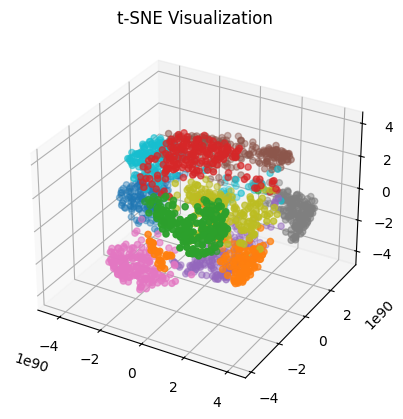

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=digits.target, cmap='tab10', marker='o')
plt.title("t-SNE Visualization")
plt.show()